# Exploration - What does the data look like, how trustworthy is it, what structure or signals does it contain?

## Will linear regression struggle with this data?
1. Skewed features that you may need to log transform
2. Nonlinear patterns vs target might violate linearity
3. Extreme outliers can wreck OLS
4. Highly correlated predictors is a multicollinearity risk
5. Heterogeneous variance visually hints at heteroscedasticity

## This is a risk assessment, not formal testing

## Intro

In [ ]:
# Libraries
# Note to restart the kernel with src code updates

# 3rd Party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# linear_regression_001
from linear_regression_001.data.loader import load_raw_data
from linear_regression_001.data.preprocess import missing_summary, preprocess
from linear_regression_001.utils.paths import INTERIM


In [2]:
# Load and view dataset
df = load_raw_data('insurance.csv')
df

*normalized*
*missing checked*
*schema enforced*


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


Data Dictionary

Features:

- age is the age of the primary beneficiary
- sex is the insurance contractor gender as male or female 
- bmi is in kg/m^2 with the ideal being 18.5 to 24.9
- children is the number of children covered by health insurance or number of dependents
- smoker is smoking as yes or no
- region is the beneficiary's residential area in the US as northeast, southeast, southwest, or northwest

Target:

- charges is the individual medical cost billed by health insurance

There are 7 columns and 1338 rows. 

The target column is charges, and we have a mix of numeric and non-numeric columns to predict it.

## Basic Data Prep
1. Missing
2. Duplicates
3. Data types

### 1. Missing

In [3]:
# Check the status of missing data
missing_summary(df)

age         0.0
sex         0.0
bmi         0.0
children    0.0
smoker      0.0
region      0.0
charges     0.0
dtype: float64

It appears there is no missing data, but there could be filler numbers for missing data like -1 or 999 for numeric or Unknown for categorical.

In [4]:
# Numeric variable statistics
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


For numeric columns, there are no values like -1 for the min value or 999 in the max would be placeholders for missing data.

In [5]:
for i in df.select_dtypes(exclude='number').columns:
    print(df[i].value_counts(),"\n")

sex
male      676
female    662
Name: count, dtype: Int64 

smoker
no     1064
yes     274
Name: count, dtype: Int64 

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: Int64 



For categorical columns, there does not appear to be any potential missing category.

There is no noticeable missing data.

### 2. Duplicates

In [6]:
num_dup = df.duplicated().sum()
print(f"The number of duplicates: {num_dup}\n")
# keep = False to show all
dup_rows = df[df.duplicated(keep=False)]
print(dup_rows)

The number of duplicates: 1

     age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631


One exact duplicate exists out of the 1338 rows. 

If there were more examples, the row count frequency could have meaning such as logs, transactions, or time series which could be aggregated. 

However, since there is only one, I will choose to remove it. 

In [7]:
# Remove duplicates
print(f'Row count BEFORE dropping duplicates: {df.shape[0]}')
df_unique = df.drop_duplicates()
print(f'Row count AFTER dropping duplicates {df_unique.shape[0]}')

# Check if there are any duplicates after drop
print(f"Presence of Duplicates? \n {df_unique.duplicated().value_counts()}")

# Reset the index and assign df_unique as df
# df = df_unique.reset_index(drop=True)


Row count BEFORE dropping duplicates: 1338
Row count AFTER dropping duplicates 1337
Presence of Duplicates? 
 False    1337
Name: count, dtype: int64


### 3. Data types

Here we are checking the semantics of the data type. 

Meaning we want to match the variable data type for what it truly means in the real world:

- Are there features that should be numeric?
- Are there features that should be categorical?

In [8]:
# Datatypes of those categorized as numeric
df.select_dtypes(include='number').dtypes

age           int64
bmi         float64
children      int64
charges     float64
dtype: object

In [9]:
df.select_dtypes(include='number')

,age,bmi,children,charges
0,19,27.900,0,16884.92400
1,18,33.770,1,1725.55230
2,28,33.000,3,4449.46200
3,33,22.705,0,21984.47061
4,32,28.880,0,3866.85520
...,...,...,...,...
1333,50,30.970,3,10600.54830
1334,18,31.920,0,2205.98080
1335,18,36.850,0,1629.83350
1336,21,25.800,0,2007.94500


In [10]:
df.select_dtypes(include='number').describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


age, bmi, children, and charges are appropriately represented datatypes.

In [11]:
# Datatypes of those categorized as categorical
df.select_dtypes(exclude='number').dtypes


sex       string[python]
smoker    string[python]
region    string[python]
dtype: object

Object datatype is a string acting as a catch-all datatype. This means there can be a mix of data types like numeric and non-numeric.

In [12]:
df.select_dtypes(exclude='number')

,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest
...,...,...,...
1333,male,no,northwest
1334,female,no,northeast
1335,female,no,southeast
1336,female,no,southwest


In [13]:
for i in df.select_dtypes(exclude='number').columns:
    print(df.select_dtypes(exclude='number')[i].value_counts(), '\n')

sex
male      676
female    662
Name: count, dtype: Int64 

smoker
no     1064
yes     274
Name: count, dtype: Int64 

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: Int64 



There are no numeric columns disguised as an object datatype from values like "1" (number in quotes) or "NA" (any string value). This suggests there are no mixed datatypes.

However, later these columns should be encoded to be numerical. Given the logic, there they are nominal, so one-hot encoding would work.

Moreover, the cardinality is not high and there are no rare categories to aggregate.

In [14]:
# Clean data
df = preprocess(df)

Dropped 0 rows (> 50% missing)


## Data Splitting and Saving Cleaned Data

In [15]:
# Separating the features (X) from the target (y) -- WARNING: Presplit
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
# Separating numeric (num_feat) from categorical variables (cat_feat) -- WARNING: Presplit
num_feat = X.select_dtypes(include='number')
cat_feat = X.select_dtypes(exclude='number')

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Training split
df_train = pd.concat([X_train,y_train],axis=1)
num_feat_train = X_train.select_dtypes(include='number')
cat_feat_train = X_train.select_dtypes(exclude='number')

In [ ]:
df.to_csv(INTERIM / 'cleaned_insurance.csv',index=False)

## Target Exploration

Target exploration by itself should not yield any data leakage because I am not using features, fitting a model, or optimizing based on test-performance.

Let's look at its distribution, statistics, presence of outliers, and if it needs to be transformed.

<Axes: xlabel='charges', ylabel='Count'>

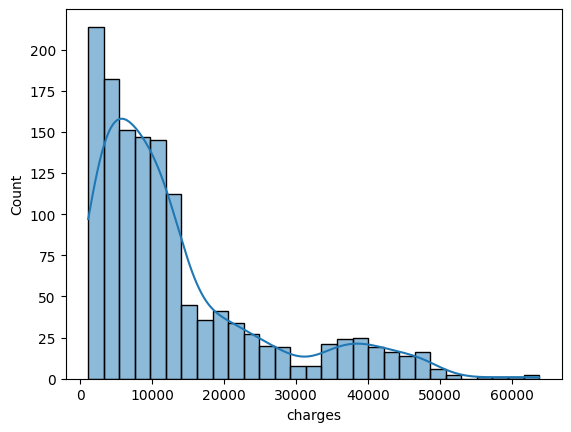

In [19]:
# Histogram of target
sns.histplot(y,kde=True)

We see that there is a right skewed with bumps around 10k and another around mid 30k to 40k.

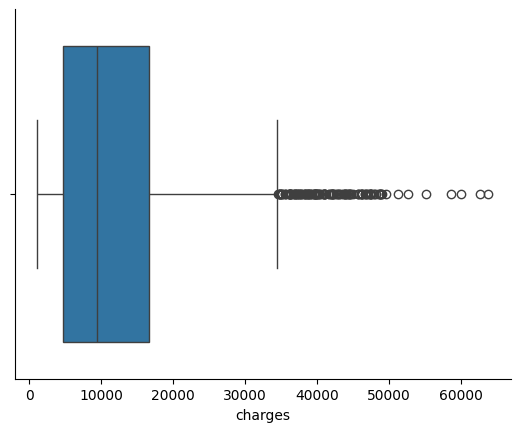

In [20]:
# Boxplot of target
sns.boxplot(x=y)
sns.despine();

Median is about 10k. There are also outliers present as a right-skew, suggesting a transformation like log-transformation later.

<Axes: xlabel='charges'>

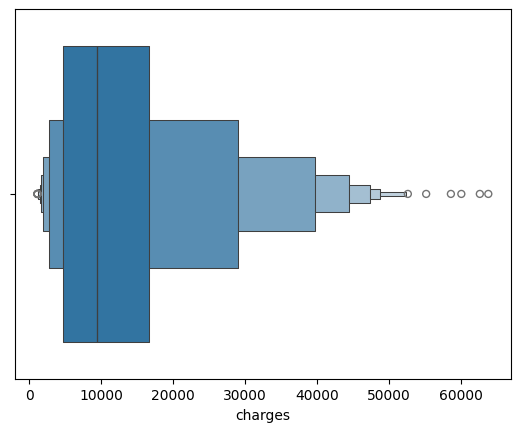

In [21]:
# Boxenplot to see relative frequency within boxplot for target
sns.boxenplot(y,orient='h')

In [22]:
# Target statistics
y.describe()

count     1337.000000
mean     13279.121487
std      12110.359656
min       1121.873900
25%       4746.344000
50%       9386.161300
75%      16657.717450
max      63770.428010
Name: charges, dtype: float64

The range of values are from around 1121.87 to around 63770.43.

Most values are between 4746.34 to 16657.72.

The median is 9386.16 and the mean is about 13279.12, reflecting the right skew from the mean pulled to the right.

## Feature Exploration

Feature exploration with the pre-split dataset should not cause data-leakage because the target info is not involved, there are no modeling decisions that are based on future outcomes.

Let's look at its distribution, statistics, presence of outliers, and if it needs to be transformed.

### Numeric

In [23]:
# Review of numeric and categorical features -- head
print(f'Numerical Features: \n {num_feat.head()} \n')
print(f'Categorical Features: \n {cat_feat.head()}')

Numerical Features: 
    age     bmi  children
0   19  27.900         0
1   18  33.770         1
2   28  33.000         3
3   33  22.705         0
4   32  28.880         0 

Categorical Features: 
       sex smoker     region
0  female    yes  southwest
1    male     no  southeast
2    male     no  southeast
3    male     no  northwest
4    male     no  northwest


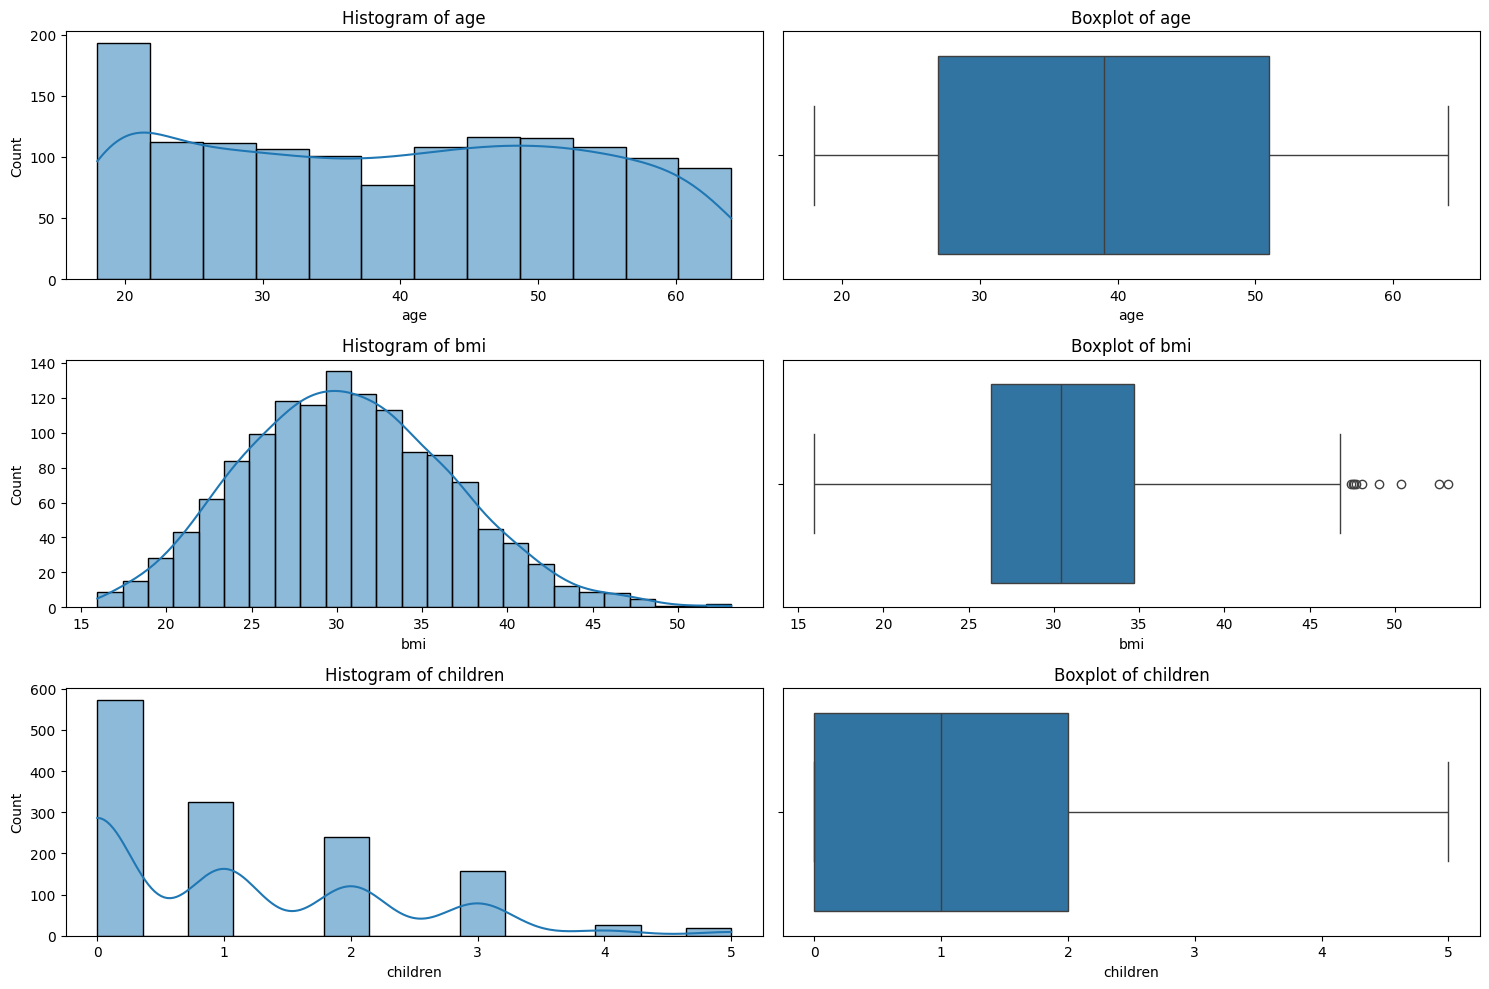

In [24]:
fig, axes = plt.subplots(num_feat.shape[1],2,figsize=(15,10))

for i, col in enumerate(num_feat.columns):

    sns.histplot(data=num_feat, x=col, ax = axes[i,0],kde=True)
    axes[i,0].set_title(f'Histogram of {col}')

    sns.boxplot(data=num_feat, x=col, ax = axes[i,1])
    axes[i,1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()



In [25]:
num_feat.describe()

,age,bmi,children
count,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737
std,14.044333,6.100468,1.205571
min,18.000000,15.960000,0.000000
25%,27.000000,26.290000,0.000000
50%,39.000000,30.400000,1.000000
75%,51.000000,34.700000,2.000000
max,64.000000,53.130000,5.000000


Age is like a uniform distribution but it deviates from it with many around age 20 and another bump around mid to late 40s.

Bmi is a bell-shape distribution but has a right skew with a median of 30.4 and mean about 30.66 and a std of around 6.10. This suggests that there should be a transformation used later such as log-transform.

Children is shaped like an exponential decay with most having 0 children. 

### Categorical

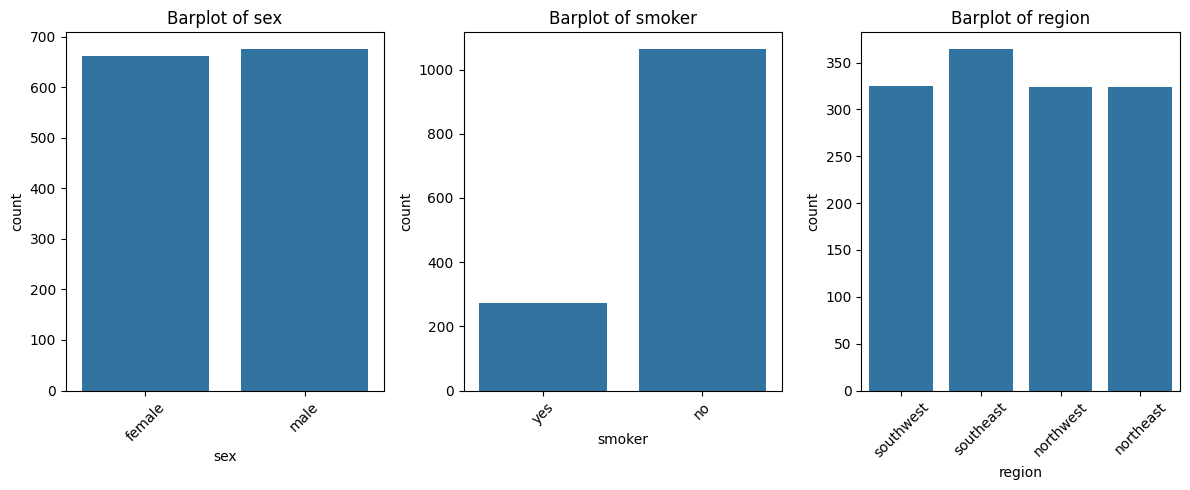

In [26]:
cat_n_cols = cat_feat.shape[1]

# squeeze is True by default and needs to be False to make this work
fig, axes = plt.subplots(1,cat_n_cols,figsize=(4*cat_n_cols,5),squeeze=False)

for i, col in enumerate(cat_feat.columns):
    sns.countplot(data=cat_feat, x=col, ax=axes[0,i])
    axes[0,i].set_title(f'Barplot of {col}')
    axes[0,i].tick_params(axis='x',rotation=45)

plt.tight_layout()
plt.show()

In [27]:
for i in cat_feat.columns:
    print(cat_feat[i].value_counts(normalize=True),'\n')

sex
male      0.504862
female    0.495138
Name: proportion, dtype: Float64 

smoker
no     0.795064
yes    0.204936
Name: proportion, dtype: Float64 

region
southeast    0.272251
southwest    0.243082
northwest    0.242334
northeast    0.242334
Name: proportion, dtype: Float64 



We want to know if there are any outliers as rare categories (<1-5%). There is none, so we do not need to aggregate.

## Feature-Feature Relationships

Feature-feature relationships should not have any data-leakage because it does not involve the target variable.

### Numeric-Numeric Relationships

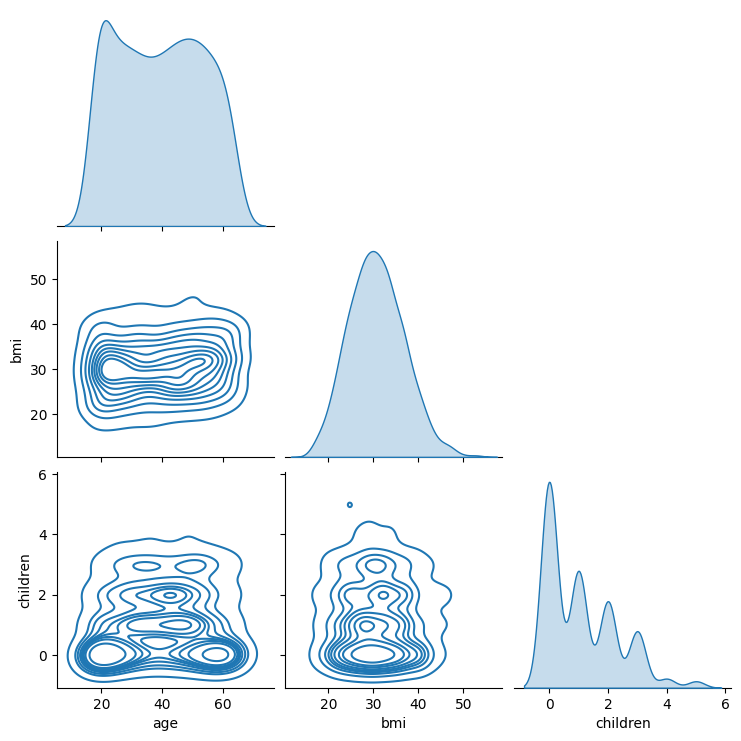

In [28]:
# Numeric-Numeric features only
sns.pairplot(num_feat,corner=True,kind='kde')

<Axes: >

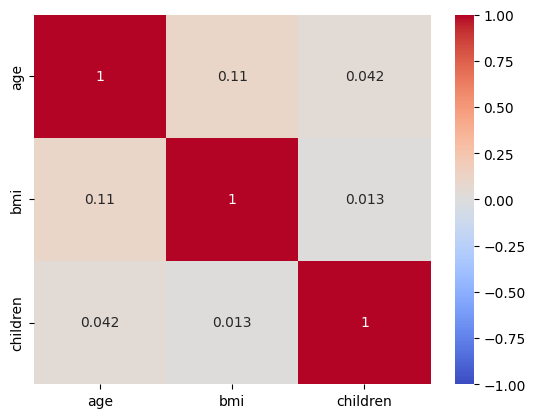

In [29]:
sns.heatmap(num_feat.corr(numeric_only=True),annot=True,vmin=-1,vmax=1,cmap='coolwarm')

There are no strong even moderate level of correlations suggesting no multicollinearity.

### Categorical-Categorical Relationships

In [30]:
contingency_table_smoker_sex = pd.crosstab(df["smoker"],df["sex"])
print("Contingency Table:")
print(contingency_table_smoker_sex)

Contingency Table:
sex     female  male
smoker              
no         547   516
yes        115   159


In [31]:
stat, p, dof, expected = chi2_contingency(contingency_table_smoker_sex)
print(f"Chi-squared statistic: {stat:.3f}")
print(f"P-value: {p:.3f}")

print('Smoker and Sex Relationship')
alpha = 0.05
if p <= alpha:
    print("Dependent - Reject null hypothesis - there is a relationship")
else:
    print("Independent - Fail to reject null hypothesis - no significant relationshiop")

Chi-squared statistic: 7.469
P-value: 0.006
Smoker and Sex Relationship
Dependent - Reject null hypothesis - there is a relationship


In [32]:
contingency_table_smoker_region = pd.crosstab(df["smoker"],df["region"])
print("Contingency Table:")
print(contingency_table_smoker_region)


Contingency Table:
region  northeast  northwest  southeast  southwest
smoker                                            
no            257        266        273        267
yes            67         58         91         58


In [33]:
stat, p, dof, expected = chi2_contingency(contingency_table_smoker_region)
print(f"Chi-squared statistic: {stat:.3f}")
print(f"P-value: {p:.3f}")

print('Smoker and Region Relationship')

alpha = 0.05
if p <= alpha:
    print("Dependent - Reject null hypothesis - there is a relationship")
else:
    print("Independent - Fail to reject null hypothesis - no significant relationshiop")

Chi-squared statistic: 7.278
P-value: 0.064
Smoker and Region Relationship
Independent - Fail to reject null hypothesis - no significant relationshiop


In [34]:
contingency_table_sex_region = pd.crosstab(df["sex"],df["region"])
print("Contingency Table:")
print(contingency_table_sex_region)

Contingency Table:
region  northeast  northwest  southeast  southwest
sex                                               
female        161        164        175        162
male          163        160        189        163


In [35]:
stat, p, dof, expected = chi2_contingency(contingency_table_sex_region)
print(f"Chi-squared statistic: {stat:.3f}")
print(f"P-value: {p:.3f}")

print('Sex and Region Relationship')

alpha = 0.05
if p <= alpha:
    print("Dependent - Reject null hypothesis - there is a relationship")
else:
    print("Independent - Fail to reject null hypothesis - no significant relationshiop")

Chi-squared statistic: 0.477
P-value: 0.924
Sex and Region Relationship
Independent - Fail to reject null hypothesis - no significant relationshiop


### Numerical-Categorical Relationships

In [36]:
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

In [37]:
# numerical - Age, bmi, children
# categorical - smoker (2), sex (2), region (4)

# T-test for binary category -- Ho if no difference | H1 is significant diff from mean
# scipy.stats import ttest_ind

# ANOVA for categorical variable with 2 or more groups -- Ho means numerical var are equal across all groups | H1 at least 1 group's mean is different from the others
# scipy.stats import f_oneway

# Smoker

age_smoker = df[df['smoker']=='yes']['age']
age_nonsmoker = df[df['smoker']=='no']['age']

t_stat, p_value = ttest_ind(age_smoker, age_nonsmoker)
print('Age vs Smoker Relationship')
print(f"p-value: {p_value}")
if p_value < 0.05:
    print("Reject null hypothesis - There is a significant difference in means\n")
else:
    print("Accept null hypothesis - There is no significant difference in means\n")


bmi_smoker = df[df['smoker']=='yes']['bmi']
bmi_nonsmoker = df[df['smoker']=='no']['bmi']

t_stat, p_value = ttest_ind(bmi_smoker, bmi_nonsmoker)
print('Bmi vs Smoker Relationship')
print(f"p-value: {p_value}")
if p_value < 0.05:
    print("Reject null hypothesis - There is a significant difference in means\n")
else:
    print("Accept null hypothesis - There is no significant difference in means\n")


children_smoker = df[df['smoker']=='yes']['children']
children_nonsmoker = df[df['smoker']=='no']['children']

t_stat, p_value = ttest_ind(children_smoker, children_nonsmoker)
print('Children vs Smoker Relationship')
print(f"p-value: {p_value}")
if p_value < 0.05:
    print("Reject null hypothesis - There is a significant difference in means\n")
else:
    print("Accept null hypothesis - There is no significant difference in means\n")





Age vs Smoker Relationship
p-value: 0.3498546857007494
Accept null hypothesis - There is no significant difference in means

Bmi vs Smoker Relationship
p-value: 0.8911471317222854
Accept null hypothesis - There is no significant difference in means

Children vs Smoker Relationship
p-value: 0.7888385727704449
Accept null hypothesis - There is no significant difference in means



In [38]:
# Sex
age_male = df[df['sex']=='male']['age']
age_female = df[df['sex']=='female']['age']

t_stat, p_value = ttest_ind(age_male, age_female)
print('Age vs Sex Relationship')
print(f"p-value: {p_value}")
if p_value < 0.05:
    print("Reject null hypothesis - There is a significant difference in means\n")
else:
    print("Accept null hypothesis - There is no significant difference in means\n")



bmi_male = df[df['sex']=='male']['bmi']
bmi_female = df[df['sex']=='female']['bmi']

t_stat, p_value = ttest_ind(bmi_smoker, bmi_nonsmoker)
print('Bmi vs Sex Relationship')
print(f"p-value: {p_value}")
if p_value < 0.05:
    print("Reject null hypothesis - There is a significant difference in means\n")
else:
    print("Accept null hypothesis - There is no significant difference in means\n")


children_male = df[df['sex']=='male']['children']
children_female = df[df['sex']=='female']['children']

t_stat, p_value = ttest_ind(children_smoker, children_nonsmoker)
print('Children vs Sex Relationship')
print(f"p-value: {p_value}")
if p_value < 0.05:
    print("Reject null hypothesis - There is a significant difference in means\n")
else:
    print("Accept null hypothesis - There is no significant difference in means\n")

Age vs Sex Relationship
p-value: 0.46914167254387895
Accept null hypothesis - There is no significant difference in means

Bmi vs Sex Relationship
p-value: 0.8911471317222854
Accept null hypothesis - There is no significant difference in means

Children vs Sex Relationship
p-value: 0.7888385727704449
Accept null hypothesis - There is no significant difference in means



In [39]:
# ANOVA region to age, bmi, children

age_northwest = df[df['region']=='northwest']['age']
age_northeast = df[df['region']=='northeast']['age']
age_southwest = df[df['region']=='southwest']['age']
age_southeast = df[df['region']=='southeast']['age']

f_stat, p_value = f_oneway(age_northwest, age_northeast, age_southwest, age_southeast)

print(f"p-value: {p_value}")

print("Age vs Region Relationship")
if p_value < 0.05:
    print("Reject the Null Hypothesis: There is a significant difference in means.\n")
else:
    print("Accept Null Hypothesis: There is no significant difference in means.\n")


bmi_northwest = df[df['region']=='northwest']['bmi']
bmi_northeast = df[df['region']=='northeast']['bmi']
bmi_southwest = df[df['region']=='southwest']['bmi']
bmi_southeast = df[df['region']=='southeast']['bmi']

f_stat, p_value = f_oneway(bmi_northwest, bmi_northeast, bmi_southwest, bmi_southeast)

print(f"p-value: {p_value}")

print("Bmi vs Region Relationship")
if p_value < 0.05:
    print("Reject the Null Hypothesis: There is a significant difference in means.\n")
else:
    print("Accept Null Hypothesis: There is no significant difference in means.\n")


children_northwest = df[df['region']=='northwest']['children']
children_northeast = df[df['region']=='northeast']['children']
children_southwest = df[df['region']=='southwest']['children']
children_southeast = df[df['region']=='southeast']['children']

f_stat, p_value = f_oneway(children_northwest, children_northeast, children_southwest, children_southeast)

print(f"p-value: {p_value}")

print("Children vs Region Relationship")
if p_value < 0.05:
    print("Reject the Null Hypothesis: There is a significant difference in means.\n")
else:
    print("Accept Null Hypothesis: There is no significant difference in means.\n")



p-value: 0.9704766241943075
Age vs Region Relationship
Accept Null Hypothesis: There is no significant difference in means.

p-value: 1.90872939274534e-24
Bmi vs Region Relationship
Reject the Null Hypothesis: There is a significant difference in means.

p-value: 0.5251145784906334
Children vs Region Relationship
Accept Null Hypothesis: There is no significant difference in means.



## Feature-Target Relationships

Feature-Target Relationships can lead to data-leakage so the training dataset should be used when exploring this section.

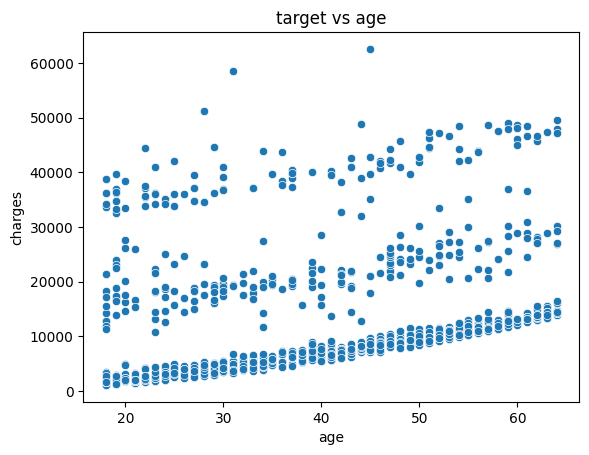

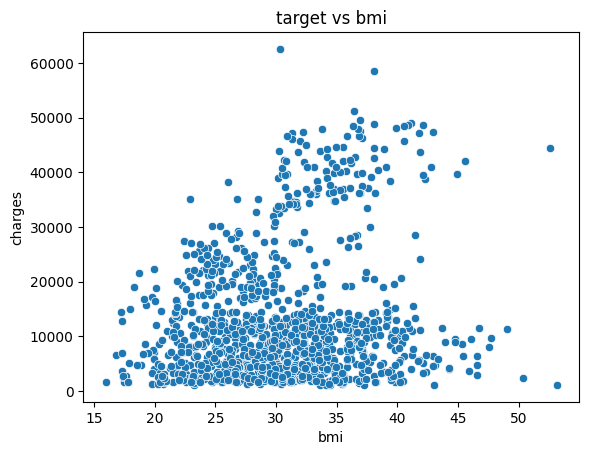

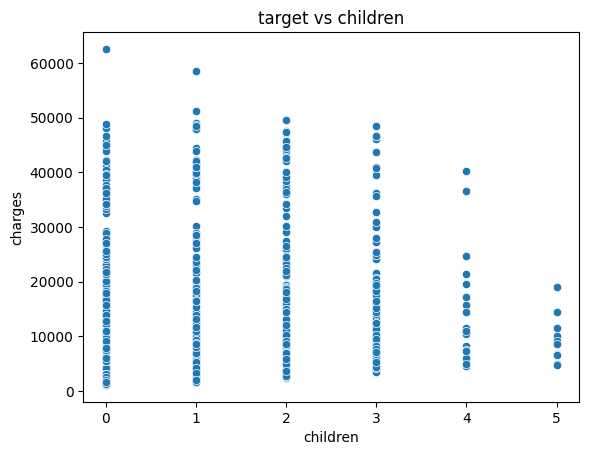

In [40]:
for col in num_feat_train.columns:
    sns.scatterplot(df_train,x=col,y='charges')
    plt.title(f'target vs {col}')
    plt.show()

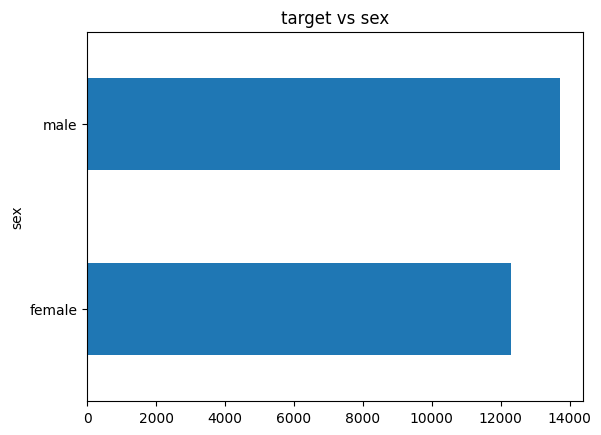

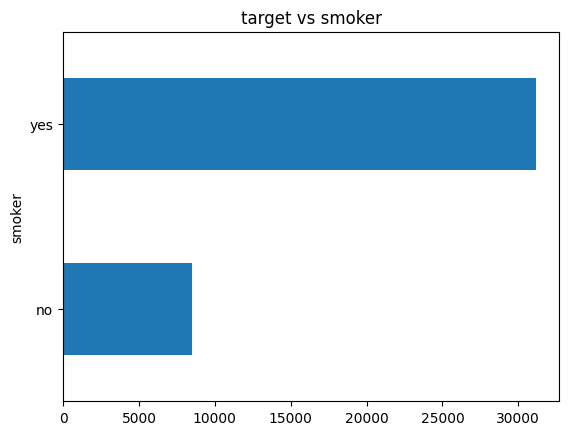

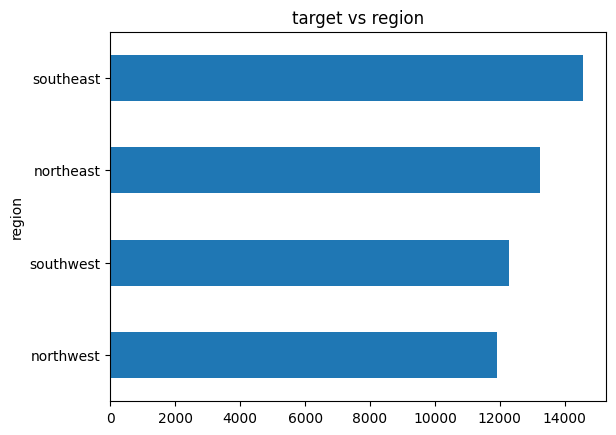

In [41]:
for col in cat_feat_train.columns:
    df_train.groupby(col)['charges'].mean().sort_values().plot.barh()
    plt.title(f'target vs {col}')
    plt.show()

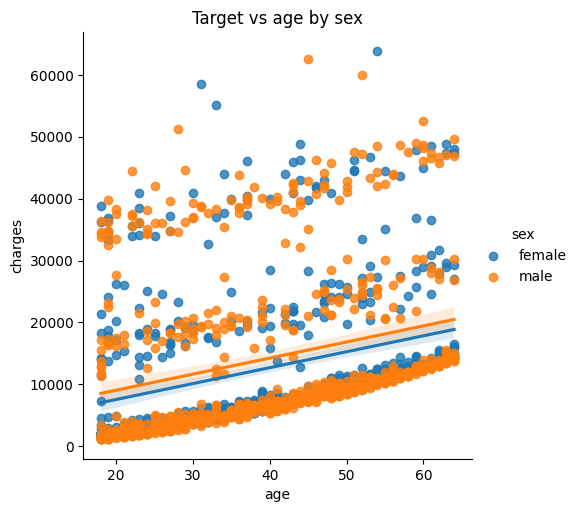

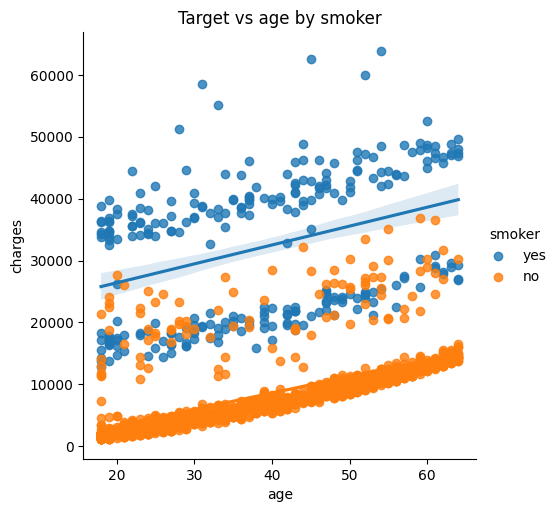

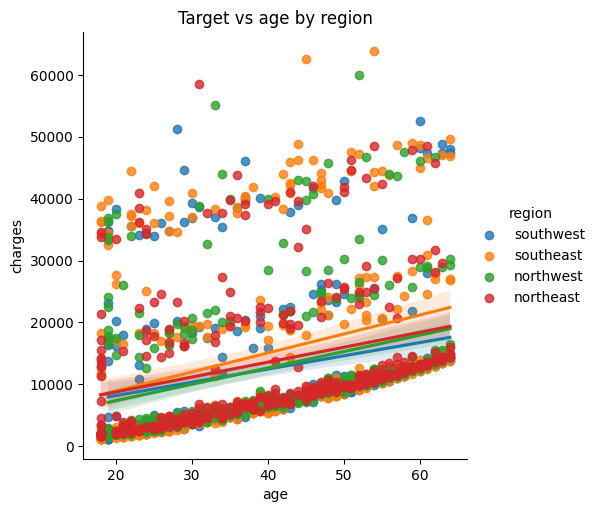

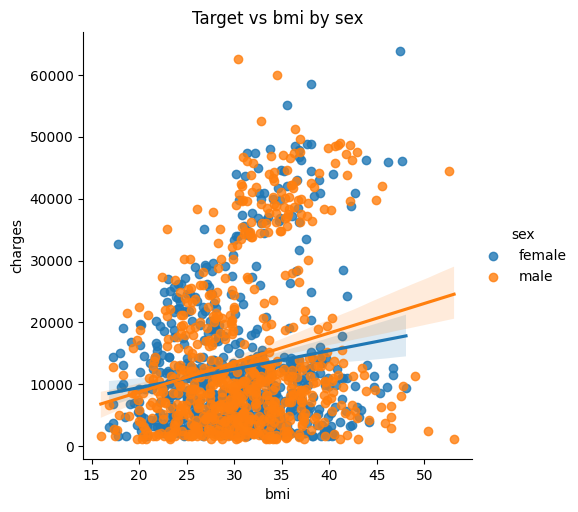

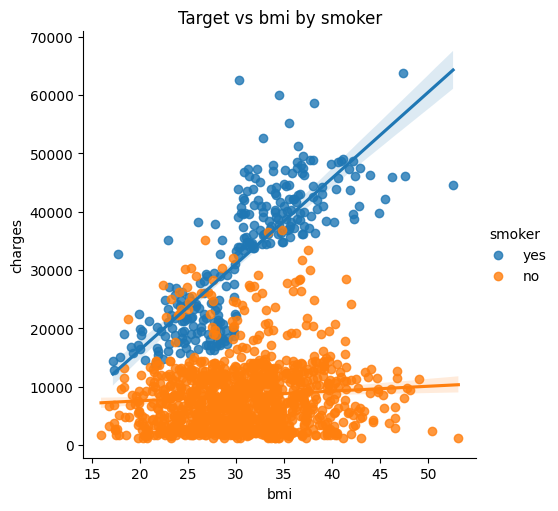

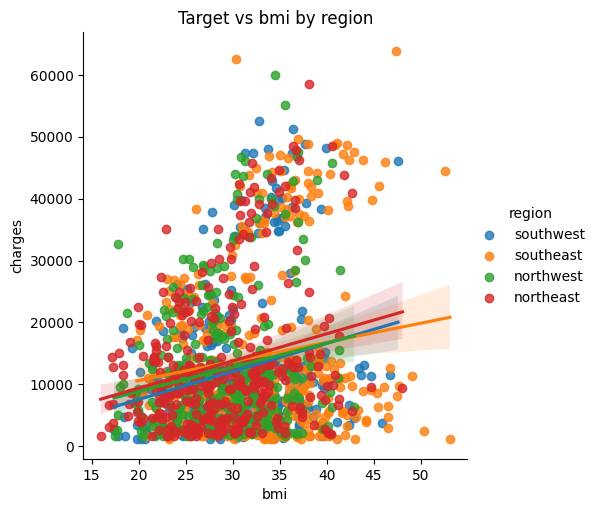

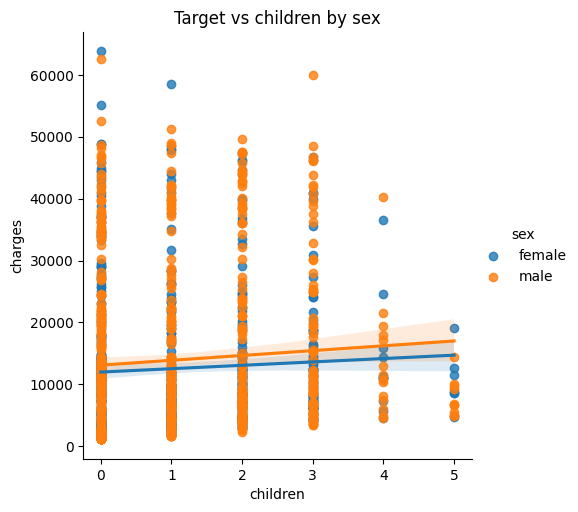

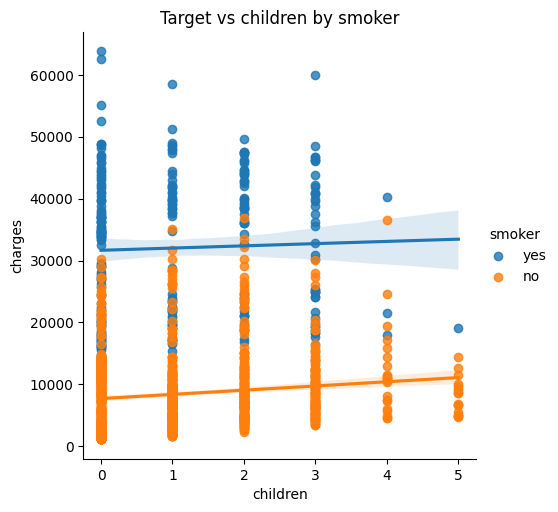

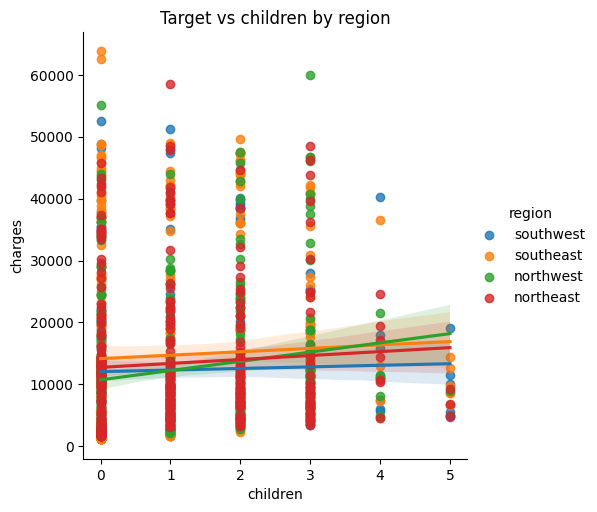

In [42]:
# Target vs Numeric by Categorical
for num_col in num_feat_train.columns:
    for cat_col in cat_feat_train.columns:
        sns.lmplot(df,x=num_col,y='charges',hue=cat_col)
        plt.title(f'Target vs {num_col} by {cat_col}')
        plt.show()

Smoker is an important variable. Bmi and smoking have a combined effect for distinction of charge.